In [15]:
import pandas as pd
import IPython.display as display
from tensorflow.keras import layers
import numpy as np
import os, random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model


In [2]:
import tensorflow as tf
print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("List of GPUs: ", tf.config.list_physical_devices('GPU'))


2.16.1
Num GPUs Available:  4
List of GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [3]:
# # ========== Download Dataset ==========
# #!pip install -U gdown
# import gdown, zipfile
# file_id = "1eyrNGFlM83pf-TETo30Cvjm7kYuCFAqu" # <-- from your real zip file link
# gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)
# with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
#     zip_ref.extractall("dataset")

In [4]:
# ==========Dataset Preparation ==========
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64
def get_pathframe(path):
    '''
    Get all the images paths and its corresponding labels
    Store them in pandas dataframe
    '''
    filenames = os.listdir(path)
    categories = []
    paths=[]
    for filename in filenames:
        paths.append(path+filename)
        category = filename.split('.')[0]
        if category == 'dog':
            categories.append(1)
        else:
            categories.append(0)
    df= pd.DataFrame({
        'filename': filenames,
        'category': categories,
        'paths':paths
    })
    return df
df=get_pathframe("dataset/dataset/")
df.tail(5)

,filename,category,paths
24995,dog.8008.jpg,1,dataset/dataset/dog.8008.jpg
24996,dog.1992.jpg,1,dataset/dataset/dog.1992.jpg
24997,dog.12412.jpg,1,dataset/dataset/dog.12412.jpg
24998,cat.2701.jpg,0,dataset/dataset/cat.2701.jpg
24999,cat.10148.jpg,0,dataset/dataset/cat.10148.jpg


In [5]:
# ========== Convert to tensor ==========
def load_and_preprocess_image(path):
    '''
    Load each image and resize it to desired shape
    '''
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image /= 255.0 # normalize to [0,1] range
    return image

def convert_to_tensor(df):
    '''
    Convert each data and labels to tensor
    '''
    path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
    image_ds = path_ds.map(load_and_preprocess_image)
    # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
    onehot_label=tf.cast(df['category'], tf.int64)
    label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)
    return image_ds,label_ds

X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


2025-04-23 22:32:11.339358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22162 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-04-23 22:32:11.340543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22162 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9
2025-04-23 22:32:11.341677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22162 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:81:00.0, compute capability: 8.9
2025-04-23 22:32:11.342787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22162 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 4090

In [6]:
#Plot Images
def get_datasets(X, Y, split_index=22500, batch_size=32, seed=0):
    dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000, seed=seed, reshuffle_each_iteration=False)
    dataset_train=dataset.take(split_index)
    dataset_test=dataset.skip(split_index)
    dataset_train=dataset_train.batch(batch_size, drop_remainder=True)
    dataset_test=dataset_test.batch(batch_size, drop_remainder=True)
    return dataset_train, dataset_test

dataset_train, dataset_test = get_datasets(X, Y, batch_size=BATCH_SIZE, seed=0)

2025-04-23 22:32:12.045709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


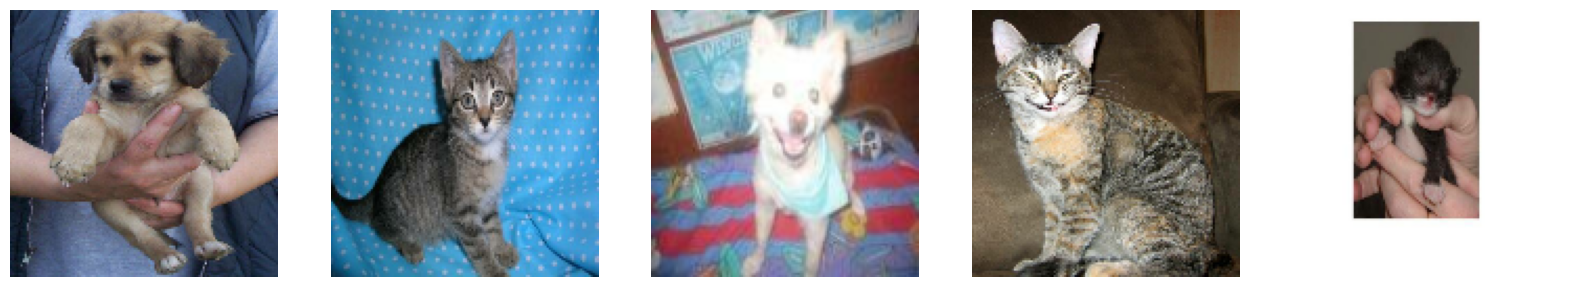

In [7]:
def plotimages(imagesls):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for image,ax in zip(imagesls, axes):
        ax.imshow(image)
        ax.axis('off')
        
imagesls=[]
for n, image in enumerate(X.take(5)):
    imagesls.append(image) 
plotimages(imagesls)

In [8]:
#Model Design
def My_CNNmodel():
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu',
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(16, (3, 3),
    padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (3, 3),
    padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (3, 3),
    padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    opt=tf.keras.optimizers.Adam(0.001)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
        metrics=['accuracy']
    )
    return model

model=My_CNNmodel()
model.summary()

/mnt/nfs/work/david97099/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,705 (8.10 MB)

 Trainable params: 2,122,705 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Plot training results
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axs[0].plot(range(1, len(model_history.history[acc]) + 1),
    model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1),
    model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1))
    axs[0].legend(['train', 'val'], loc='best')
    
    # Loss plot
    axs[1].plot(range(1, len(model_history.history['loss']) + 1),
    model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1),
    model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.tight_layout()
    plt.show()
    

Epoch 1/2


I0000 00:00:1745418733.141888  779548 service.cc:145] XLA service 0x7f747800c9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745418733.141981  779548 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1745418733.141984  779548 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1745418733.141987  779548 service.cc:153]   StreamExecutor device (2): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1745418733.141989  779548 service.cc:153]   StreamExecutor device (3): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-23 22:32:13.158441: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-23 22:32:13.268762: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8903


 61/351 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5104 - loss: 0.7923

I0000 00:00:1745418734.384031  779548 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5824 - loss: 0.6868 - val_accuracy: 0.7340 - val_loss: 0.5291
Epoch 2/2
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7410 - loss: 0.5254 - val_accuracy: 0.7796 - val_loss: 0.4716


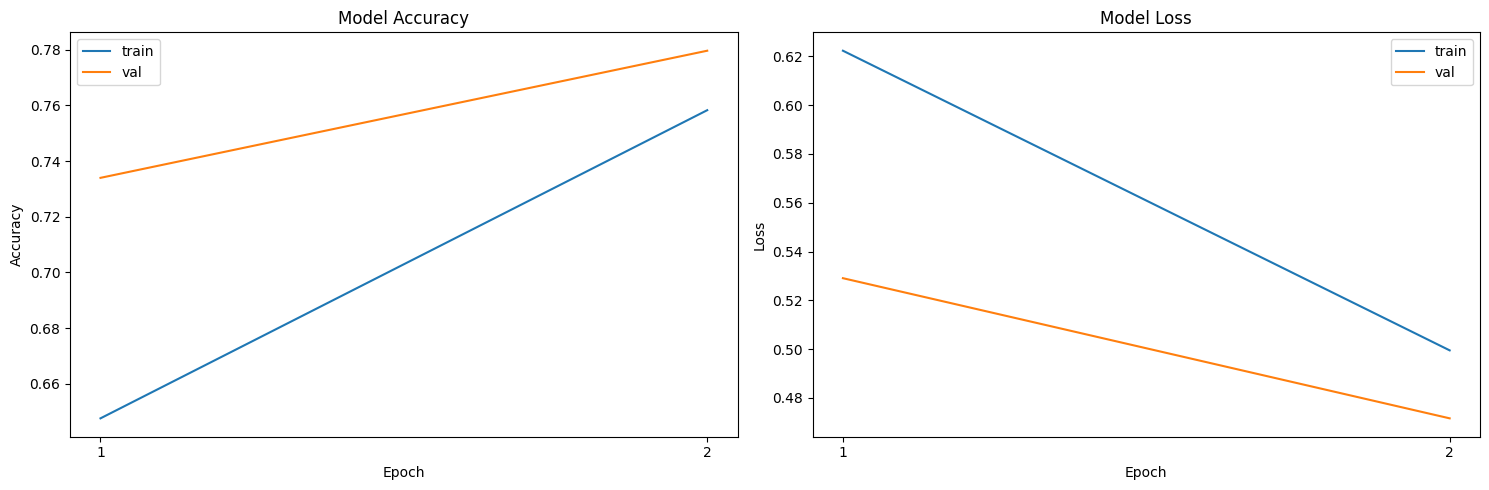

In [10]:
# Init
model=My_CNNmodel()

#Training the model
#You can adjust the epochs to get better training results, be aware with overfitting
baseline_hist=model.fit(dataset_train, epochs=2, validation_data=dataset_test)

#Save trained model
os.makedirs("weights", exist_ok=True)
model.save("weights/baseline.keras") #Save the model with your student ID

plot_model_history(baseline_hist)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7762 - loss: 0.4714 
Test: accuracy = 0.779647 ; loss = 0.471637 
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 


2025-04-23 22:32:20.531828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


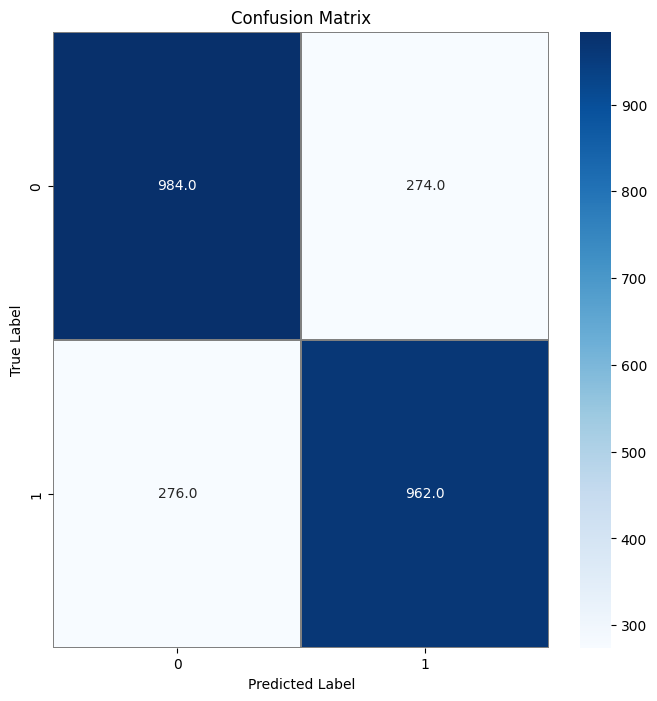

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1258
           1       0.78      0.78      0.78      1238

    accuracy                           0.78      2496
   macro avg       0.78      0.78      0.78      2496
weighted avg       0.78      0.78      0.78      2496



In [11]:
# Evaluate the model
def eval_model(model, dataset_test):
    loss, accuracy = model.evaluate(dataset_test)
    print("Test: accuracy = %f ; loss = %f " % (accuracy, loss))

    # Predict values
    y_pred = model.predict(dataset_test)
    y_p = np.where(y_pred > 0.5, 1, 0) # for binary classification

    # Extract ground truth labels
    test_data = dataset_test.unbatch()
    y_g = []
    for image, label in test_data:
        y_g.append(label.numpy())
        
    # Convert to flat array if needed
    y_g = np.array(y_g).flatten()
    y_p = y_p.flatten()

    # Compute confusion matrix
    confusion_mtx = confusion_matrix(y_g, y_p)

    # Plot
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Blues",
    linecolor="gray", fmt='.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Generate a classification report
    report = classification_report(y_g, y_p, target_names=['0','1'])
    print(report)
    
eval_model(model, dataset_test)

Epoch 1/100


/mnt/nfs/work/david97099/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


348/351 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5914 - loss: 0.6611
Epoch 1: val_accuracy improved from -inf to 0.72877, saving model to weights/best_more_epochs_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5921 - loss: 0.6605 - val_accuracy: 0.7288 - val_loss: 0.5324
Epoch 2/100
336/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7625 - loss: 0.4969
Epoch 2: val_accuracy improved from 0.72877 to 0.78806, saving model to weights/best_more_epochs_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7632 - loss: 0.4958 - val_accuracy: 0.7881 - val_loss: 0.4424
Epoch 3/100
333/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8083 - loss: 0.4178
Epoch 3: val_accuracy improved from 0.78806 to 0.81370, saving model to weights/best_more_epochs_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8087 - loss: 0.4170 - val_accuracy: 0.8137 - val_loss: 0.4197
Epoch 4/100
335/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8342 - lo

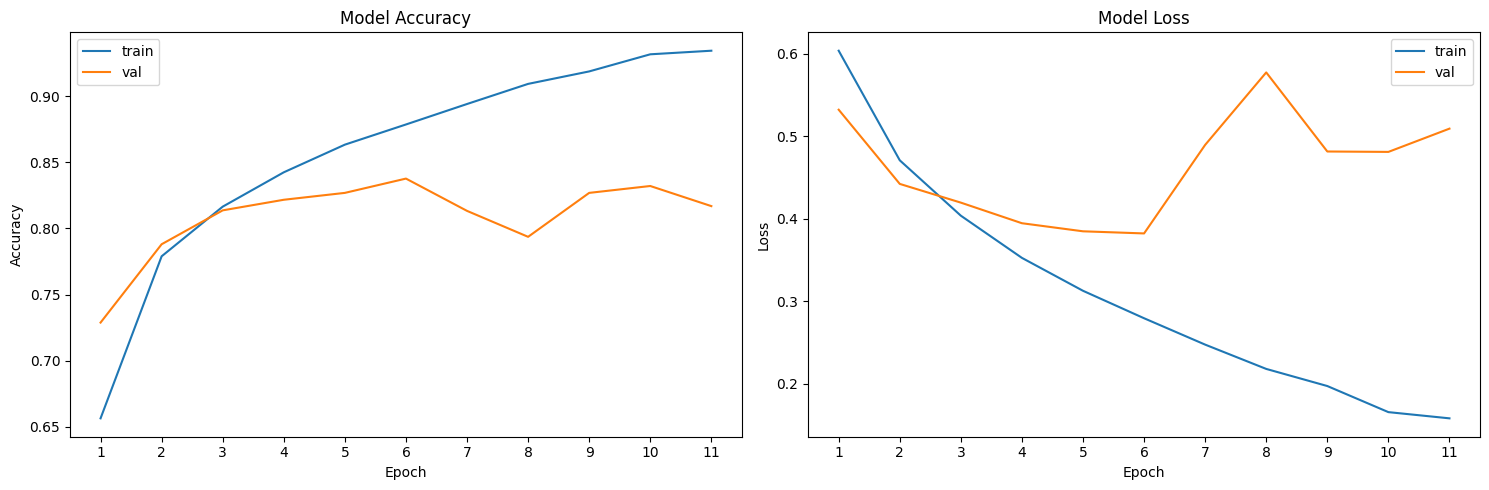

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8390 - loss: 0.3797 
Test: accuracy = 0.837740 ; loss = 0.382397 
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step 


2025-04-23 22:32:44.253892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


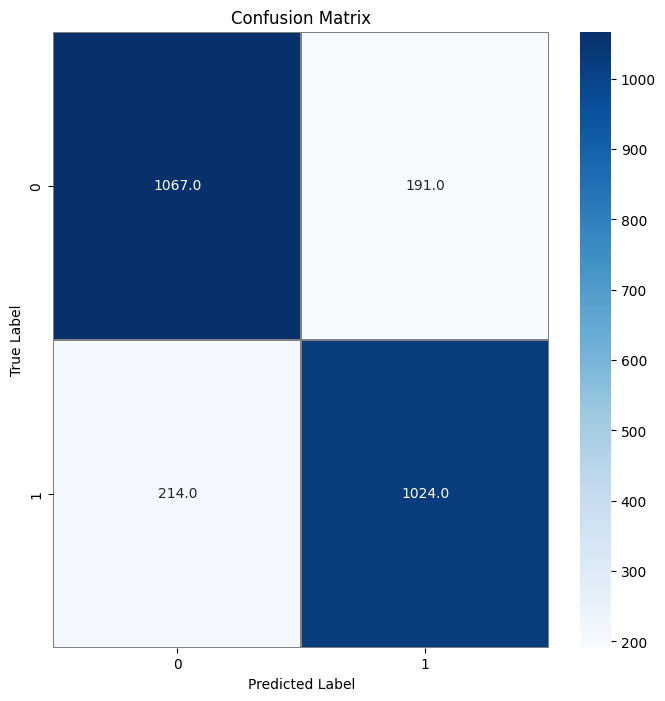

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1258
           1       0.84      0.83      0.83      1238

    accuracy                           0.84      2496
   macro avg       0.84      0.84      0.84      2496
weighted avg       0.84      0.84      0.84      2496



In [12]:
model_name = "more_epochs_model"
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)
final_model_path = f"{save_dir}/{model_name}.keras"
best_model_path = f"{save_dir}/best_{model_name}.keras"

model = My_CNNmodel()

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_test,
    callbacks=[early_stop, checkpoint],
)
    
# Save trained model
os.makedirs("weights", exist_ok=True)
model.save(final_model_path) # Save the model with your student ID

plot_model_history(history)
best_model = load_model(best_model_path)

dataset_train, dataset_test = get_datasets(X, Y, batch_size=BATCH_SIZE)
eval_model(best_model, dataset_test)

# Model Redisign

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import register_keras_serializable

# A custom residual block that handles channel mismatches
@register_keras_serializable()
class ResidualBlock(layers.Layer):
    def __init__(self, filters, stride=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.stride = stride

        # Main path conv layers
        self.conv1 = layers.Conv2D(filters, 3, strides=stride, padding='same')
        self.bn1   = layers.BatchNormalization()
        self.act1  = layers.Activation('relu')

        self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.bn2   = layers.BatchNormalization()

        # Final activation
        self.final_act = layers.Activation('relu')

        # Shortcut layers: will be created in build()
        self.shortcut_conv = None
        self.shortcut_bn   = None

    def build(self, input_shape):
        # input_shape[-1] is the number of channels in the input tensor
        input_channels = input_shape[-1]
        # If spatial dims change (stride != 1) OR channel count changes, project shortcut
        if self.stride != 1 or input_channels != self.filters:
            self.shortcut_conv = layers.Conv2D(
                self.filters, 1, strides=self.stride, padding='same'
            )
            self.shortcut_bn = layers.BatchNormalization()
        super().build(input_shape)

    def call(self, inputs, training=False):
        # Main branch
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # Shortcut branch
        shortcut = inputs
        if self.shortcut_conv:
            shortcut = self.shortcut_conv(shortcut)
            shortcut = self.shortcut_bn(shortcut, training=training)

        # Combine and final activation
        out = layers.add([x, shortcut])
        return self.final_act(out)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "stride": self.stride,
        })
        return config

# Build a ResUNet‐like classifier from scratch
def ResUNet(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder: initial downsampling
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    skip1 = x
    x = layers.MaxPooling2D(2, padding='same')(x)

    # Residual block group 1
    x = ResidualBlock(64, stride=1)(x)
    x = ResidualBlock(64, stride=1)(x)
    skip2 = x
    x = layers.MaxPooling2D(2, padding='same')(x)

    # Residual block group 2
    x = ResidualBlock(128, stride=1)(x)
    x = ResidualBlock(128, stride=1)(x)
    skip3 = x
    x = layers.MaxPooling2D(2, padding='same')(x)

    # Residual block group 3
    x = ResidualBlock(256, stride=1)(x)
    x = ResidualBlock(256, stride=1)(x)
    skip4 = x
    x = layers.MaxPooling2D(2, padding='same')(x)

    # Bridge
    x = ResidualBlock(512, stride=1)(x)
    x = ResidualBlock(512, stride=1)(x)

    # Decoder with upsampling + skip connections
    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x, skip4])
    x = ResidualBlock(256, stride=1)(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x, skip3])
    x = ResidualBlock(128, stride=1)(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x, skip2])
    x = ResidualBlock(64, stride=1)(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x, skip1])
    x = ResidualBlock(64, stride=1)(x)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary output

    model = models.Model(inputs, outputs, name="ResUNet_Classifier")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate and inspect
model = ResUNet()
model.summary()


Model: "ResUNet_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block      │ (None, 32, 32,    │     74,368 │ max_pooling2d_12… │
│ (ResidualBlock)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_1    │ (None, 32, 32,    │     74,368 │ residual_block[0… │
│ (ResidualBlock)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ residual_block_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_2    │ (None, 16, 16,    │    231,296 │ max_pooling2d_13… │
│ (ResidualBlock)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_3    │ (None, 16, 16,    │    296,192 │ residual_block_2… │
│ (ResidualBlock)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 8, 8, 128) │          0 │ residual_block_3… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_4    │ (None, 8, 8, 256) │    921,344 │ max_pooling2d_14… │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_5    │ (None, 8, 8, 256) │  1,182,208 │ residual_block_4… │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 4, 4, 256) │          0 │ residual_block_5… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_6    │ (None, 4, 4, 512) │  3,677,696 │ max_pooling2d_15… │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_7    │ (None, 4, 4, 512) │  4,723,712 │ residual_block_6… │
│ (ResidualBlock)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 512) │          0 │ residual_block_7

 Total params: 14,688,897 (56.03 MB)

 Trainable params: 14,676,225 (55.99 MB)

 Non-trainable params: 12,672 (49.50 KB)

Epoch 1/100
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6152 - loss: 0.6550
Epoch 1: val_accuracy improved from -inf to 0.67628, saving model to weights/best_ResUNet_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.6155 - loss: 0.6547 - val_accuracy: 0.6763 - val_loss: 0.8641
Epoch 2/100
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7709 - loss: 0.4796
Epoch 2: val_accuracy improved from 0.67628 to 0.80529, saving model to weights/best_ResUNet_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7711 - loss: 0.4793 - val_accuracy: 0.8053 - val_loss: 0.4813
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8488 - loss: 0.3479
Epoch 3: val_accuracy improved from 0.80529 to 0.82131, saving model to weights/best_ResUNet_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8489 - loss: 0.3478 - val_accuracy: 0.8213 - val_loss: 0.4156
Epoch 4/100
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0

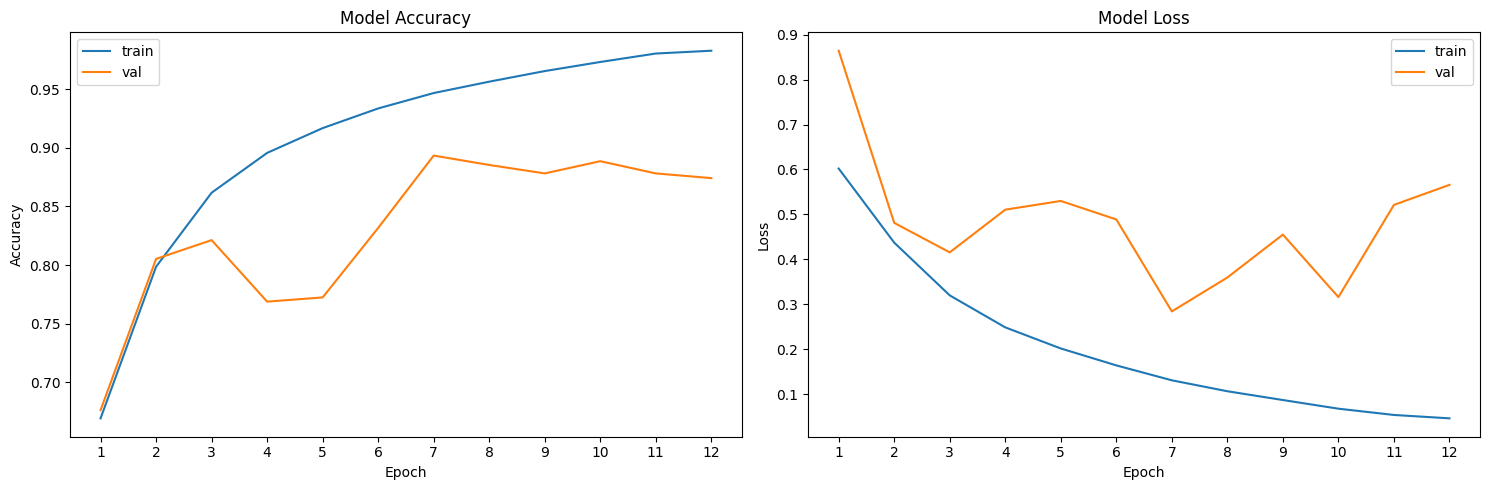

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8883 - loss: 0.2916
Test: accuracy = 0.893429 ; loss = 0.284297 
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


2025-04-23 22:35:09.649984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


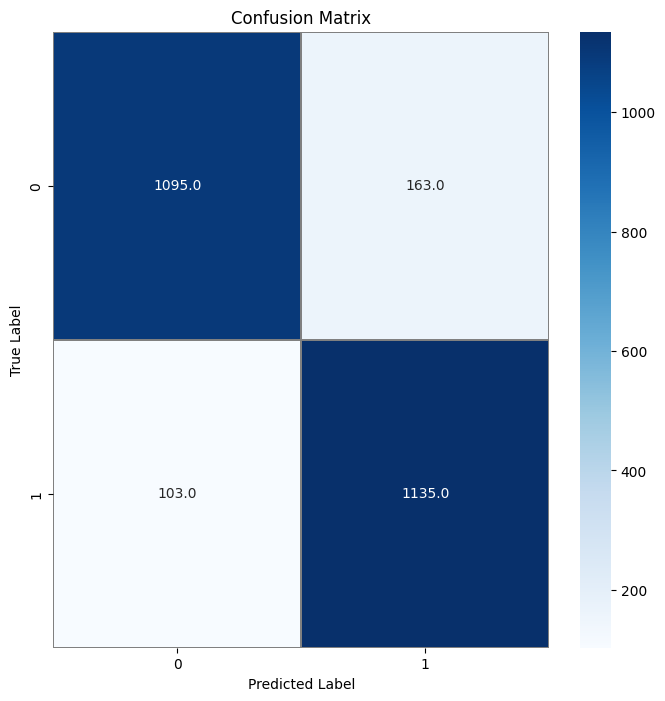

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1258
           1       0.87      0.92      0.90      1238

    accuracy                           0.89      2496
   macro avg       0.89      0.89      0.89      2496
weighted avg       0.89      0.89      0.89      2496



In [14]:
model_name = "ResUNet_model"
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)
final_model_path = f"{save_dir}/{model_name}.keras"
best_model_path = f"{save_dir}/best_{model_name}.keras"

model = ResUNet()

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_test,
    callbacks=[early_stop, checkpoint],
)
    
# Save trained model
os.makedirs("weights", exist_ok=True)
model.save(final_model_path) # Save the model with your student ID

plot_model_history(history)
best_model = load_model(
    best_model_path,
    custom_objects={'ResidualBlock': ResidualBlock}
    )

dataset_train, dataset_test = get_datasets(X, Y, batch_size=BATCH_SIZE)
eval_model(best_model, dataset_test)

Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6013 - loss: 0.6591
Epoch 1: val_accuracy improved from -inf to 0.58974, saving model to weights/best_LR_ResUNet_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6014 - loss: 0.6590 - val_accuracy: 0.5897 - val_loss: 1.4480 - learning_rate: 0.0010
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7626 - loss: 0.4978
Epoch 2: val_accuracy improved from 0.58974 to 0.72596, saving model to weights/best_LR_ResUNet_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7627 - loss: 0.4977 - val_accuracy: 0.7260 - val_loss: 0.6329 - learning_rate: 0.0010
Epoch 3/100
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8398 - loss: 0.3635
Epoch 3: val_accuracy did not improve from 0.72596
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8399 - loss: 0.3633 - val_accuracy: 0.6815 - val_loss: 0.7579 - learning_rate: 0.0010
Epoch 4/100
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 

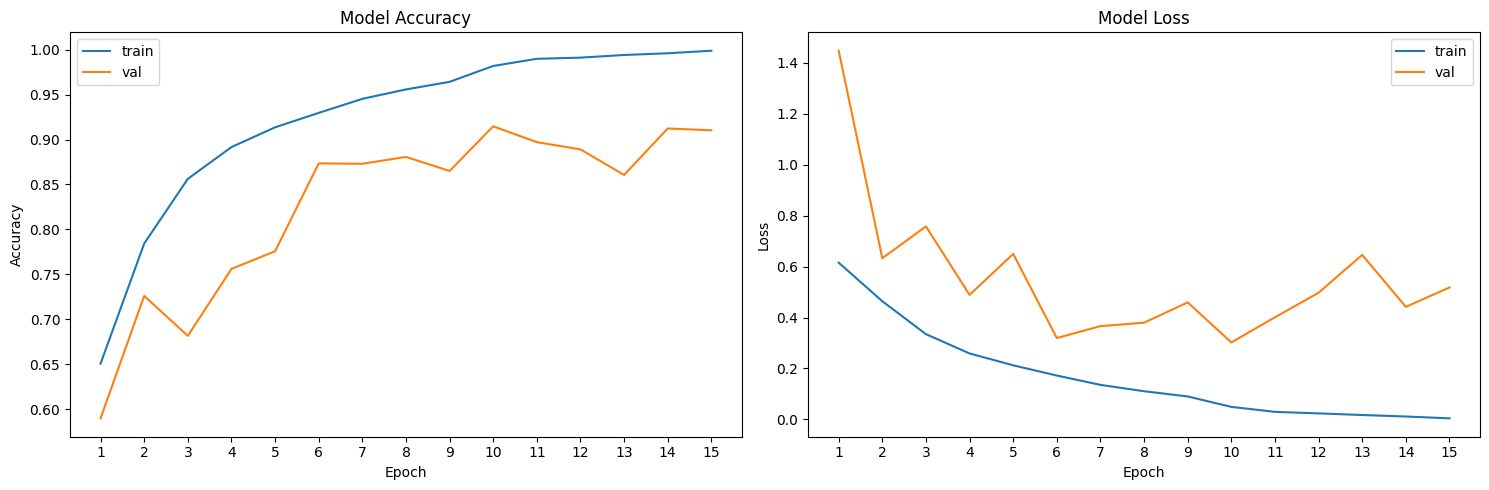

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9143 - loss: 0.3017
Test: accuracy = 0.914663 ; loss = 0.302258 
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


2025-04-23 22:44:53.932773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


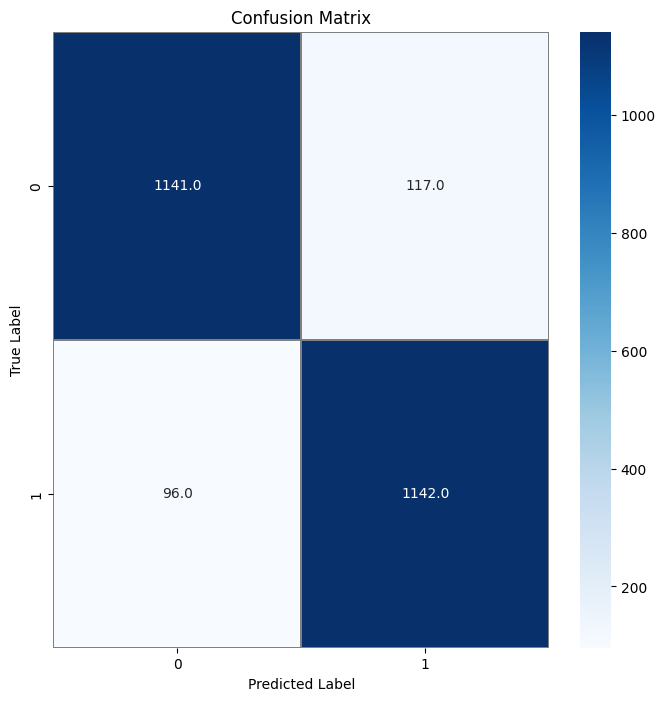

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1258
           1       0.91      0.92      0.91      1238

    accuracy                           0.91      2496
   macro avg       0.91      0.91      0.91      2496
weighted avg       0.91      0.91      0.91      2496



In [16]:
model_name = "LR_ResUNet_model"
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)
final_model_path = f"{save_dir}/{model_name}.keras"
best_model_path = f"{save_dir}/best_{model_name}.keras"

model = ResUNet()

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_test,
    callbacks=[early_stop, checkpoint, lr_scheduler],
)
    
# Save trained model
os.makedirs("weights", exist_ok=True)
model.save(final_model_path) # Save the model with your student ID

plot_model_history(history)
best_model = load_model(
    best_model_path,
    custom_objects={'ResidualBlock': ResidualBlock}
    )

dataset_train, dataset_test = get_datasets(X, Y, batch_size=BATCH_SIZE)
eval_model(best_model, dataset_test)